In [57]:
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.font_manager as fm
import seaborn as sns

In [58]:
# Please specify the folder paths containing 3 column results files from DRL and baseline schemes
###################################Change these parameters according to the scenario#################
rl_folder_path = "RL"
random_folder_path = "random"
fcfs_folder_path = "fcfs"
output_path = "plots"
####################################################################################################

if not os.path.exists(output_path):
    os.makedirs(output_path)
font_name = fm.FontProperties("Times New Roman").get_name()
font_size = 20
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'

In [59]:
def read_files(results_path, dataframe, algo):
    """
    Takes the 3 columns(Episode + episode_reward + avg. CCT) input files with filenames in the format:
    <Num_flows>-<Network_load>-distribution-<seed>*.txt.

    Returns a Pandas DataFrame with the following Columns:
        'algo', 'num-flows', 'network-load', 'seed', 'avg-cct'
    """
    for root, sub_dirs, files in os.walk(results_path):
        if len(files) > 0:
            for file in files:
                if '.csv' in file:
                    data = pd.read_csv(f'{root}/{file}', delimiter=',')
                    # aggeregating the columns incase the input files have multiples num_ros (for ALif)
                    avg_cct = data['avg_cct'].mean()
                    num_flows = file.split('-')[0]
                    # even though alif does not have the concept of queue_ratio we just add this value for simplicity 
                    network_load = float(file.split('-')[1])*100
                    seed = file.split('-')[-1].split('.')[0]
                    row = [algo, num_flows, network_load, seed, avg_cct]
                    dataframe.loc[len(dataframe)] = row

    return dataframe


def fix_dtypes(df):
    """Set correct dtypes"""
    df['num-flows'] = pd.to_numeric(df['num-flows'])
    df['network-load'] = pd.to_numeric(df['network-load'])
    df['avg-cct'] = pd.to_numeric(df['avg-cct'])

In [60]:
# defining the dataframe
dataframe = pd.DataFrame(columns=['algo', 'num-flows', 'network-load', 'seed', 'avg-cct'])
# reading input files
df = read_files(rl_folder_path, dataframe, algo='JCSR')
df = read_files(random_folder_path, df, algo='Random')
df = read_files(fcfs_folder_path, df, algo='ECMP')

df.sort_values(['algo', 'num-flows', 'network-load'], inplace=True)
df = df.reset_index(drop=1)
fix_dtypes(df)
# Finding the Mean and Std. for all the network-loads for a scheme
df_mean = df.groupby(['algo', 'num-flows', 'network-load']).mean().reset_index()
df_std = df.groupby(['algo', 'num-flows', 'network-load']).std().reset_index()
fix_dtypes(df_mean)
fix_dtypes(df_std)
display(df_mean)

,algo,num-flows,network-load,avg-cct
0,ECMP,50,10.0,25.352129
1,ECMP,50,20.0,15.862013
2,ECMP,50,30.0,17.970530
3,ECMP,50,40.0,21.666402
4,ECMP,50,50.0,19.362628
5,ECMP,50,60.0,20.543093
6,ECMP,50,70.0,17.947172
7,ECMP,50,80.0,19.888584
8,ECMP,50,90.0,18.015082
9,JCSR,50,10.0,21.772080


# Plotting Mean Avg. CCTs

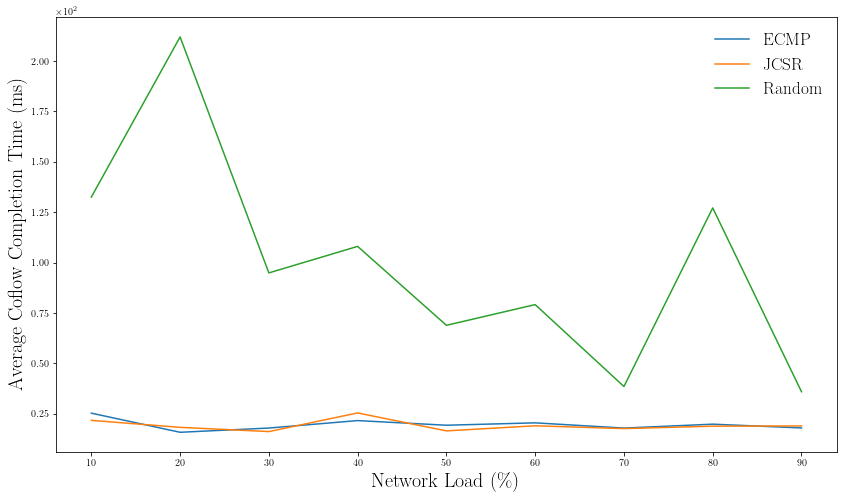

In [61]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.lineplot(x="network-load", y="avg-cct", hue="algo", data=df_mean)
ax.set_xlabel('Network Load (\%)', fontsize=font_size, fontname=font_name)
ax.set_ylabel('Average Coflow Completion Time (ms)', fontsize=font_size, fontname=font_name)
ax.legend(prop={'family': font_name, 'size': 'xx-large'}, numpoints=1, frameon=False)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.savefig(f'{output_path}/mean_avg_ccts.pdf')